In [446]:
import numpy as np
from numpy.random import Generator, MT19937, SeedSequence
import matplotlib.pyplot as plt
from scipy.sparse import spdiags,linalg,eye

In [954]:
#Implementation based on S. Schaefer's Les Houches '09 lecture notes found at 
#https://nic.desy.de/sites2009/site_nic/content/e44192/e62778/e91179/e91180/hmc_tutorial_eng.pdf

#Model parameters 
#kappa_c = 0.185825
kappa = 0.2 
lambda_val = 1.1689
latt_size = 12
ndim = 3

#Monte Carlo parameters  
ntherm = 0 #number of thermalization steps 
nmeas = 2500  #number of measurement steps  
nstep = 10 #number of HMC integration steps 
tau = 1.0  #HMC trajectory length  

#useful definitions 
vol = latt_size**ndim
epsilon = tau/nstep 

In [955]:
#Initialize pseudo-random number generator with a fixed seed.
sg = SeedSequence(234523)
gen = Generator(MT19937(sg))

In [956]:
#'Hot' start: normally distributed initial field values 
#phi = gen.normal(0, 1.0, size=vol)

#'Cold' start: all field values start at zero 
phi = np.zeros(vol)

#conjugate momentum field 
mom = np.zeros(vol)

#measurement data 
dH = np.zeros(nmeas) #Delta H values for each update 
msq = np.zeros(nmeas) #measurements of m^2 
acc = np.zeros(nmeas) #1 = accepted, 0 = not accepted 

#useful array which stores the index of the nearest neighbors of every site 
hop = np.zeros((vol, 2*ndim))
for z in range(latt_size):
    for y in range(latt_size):
        for x in range(latt_size):
            j = x + y*latt_size + z*latt_size*latt_size 
            
            hop[j,0] = (x+1)%latt_size + y*latt_size + z*latt_size*latt_size
            hop[j,1] = x + ((y+1)%latt_size)*latt_size + z*latt_size*latt_size
            hop[j,2] = x + y*latt_size + ((z+1)%latt_size)*latt_size*latt_size

            hop[j,3] = (x-1+latt_size)%latt_size + y*latt_size + z*latt_size*latt_size
            hop[j,4] = x + ((y-1+latt_size)%latt_size)*latt_size + z*latt_size*latt_size
            hop[j,5] = x + y*latt_size + ((z-1+latt_size)%latt_size)*latt_size*latt_size

In [957]:
#Perform the I_1(eps) integration step to advance the phi field 
def move_phi(eps):
    for j in range(vol):
        phi[j] += eps*mom[j]

In [958]:
#Perform the I_2(eps) integration step to advance the conjugate momentum field 
def move_mom(eps):
    for j in range(vol):
        J=0.0
        for mu in range(2*ndim):
            J+=phi[int(hop[j,mu])]
        force=2.0*kappa*J - 2.0*phi[j] - lambda_val*4.0*(phi[j]*phi[j]-1.0)*phi[j]
        mom[j]+=eps*force

In [959]:
#Perform a single leapfrog integration step 
def leapfrog():
    move_phi(0.5*epsilon)
    move_mom(epsilon)
    move_phi(0.5*epsilon)

In [960]:
def omf2():
    xi = 0.1931833275037836
    move_phi(xi*epsilon)
    move_mom(0.5*epsilon)
    move_phi((1-2.0*xi)*epsilon)
    move_mom(0.5*epsilon)
    move_phi(xi*epsilon)

In [961]:
#Compute the 'potential' V(phi) = S(phi) for the current field configuration
def potential():
    V=0.0
    for j in range(vol):
        J=0.0
        for mu in range(ndim):
            J+=phi[int(hop[j,mu])]
        phi2 = phi[j]*phi[j]
        V+=-2.0*kappa*J*phi[j] + phi2 + lambda_val*(phi2-1.0)*(phi2-1.0)
    
    return V    

In [962]:
#Compute the 'kinetic energy' K(pi) for the HMC hamiltonian
def kinetic(): 
    K=0.0
    for j in range(vol):
        K += 0.5*mom[j]*mom[j]
    
    return K

In [963]:
#Compute the average field value 
def mag():
    m_tot=0.0
    for j in range(vol):
        m_tot += phi[j]
    return m_tot

In [964]:
#Main loop to perform the simulation
for n in range(ntherm+nmeas):
    #draw a fresh momentum configuration from the unit normal distribution
    mom = gen.normal(0, 1.0, size=vol)
    
    #compute the initial value of the HMC hamiltonian 
    Hold = kinetic() + potential() 
    
    #store the current field in case the proposal is not accepted 
    phi_old = phi
    
    #perform the HMC integration over a trajectory length tau
    for m in range(nstep):
        omf2()
        #leapfrog()
    
    #compute new value of HMC Hamiltonian and Delta H
    Hnew = kinetic() + potential()
    deltaH = Hnew-Hold
    print (f'deltaH = {deltaH}')
    iacc=0 
    
    #if energy is lowered, always accept
    #if energy is raised, accept with probability pacc 
    if (deltaH<0):
        iacc=1 
    else:
        pacc = np.exp(-deltaH)
        u=gen.uniform(0,1)
        if (u<pacc):
            iacc=1
 
    #if not accepted reset to old field configuration
    if (iacc==0):
        phi=phi_old
     
    print(f'iacc = {iacc}')
    
    #if we are done with thermalization, take some measurements 
    if (n>=ntherm):
        dH[n-ntherm]=deltaH
        mtemp = mag()
        msq[n-ntherm]=mtemp*mtemp/vol
        acc[n-ntherm]=iacc 
        
    

deltaH = -2.7051282541142427
iacc = 1
deltaH = 1.4474481739162002
iacc = 0
deltaH = -0.720196207371373
iacc = 1
deltaH = 0.25746658148364077
iacc = 1
deltaH = -0.1825030560698906
iacc = 1
deltaH = 0.04899271190879517
iacc = 1
deltaH = -0.20966241752967107
iacc = 1
deltaH = 0.05155316071022753
iacc = 1
deltaH = 0.0314818076976735
iacc = 1
deltaH = 0.036215554768659786
iacc = 1
deltaH = -0.036857900191989756
iacc = 1
deltaH = 0.022439153332470596
iacc = 1
deltaH = 0.03640885343747868
iacc = 1
deltaH = -0.15311870850518972
iacc = 1
deltaH = 0.11108043052308858
iacc = 1
deltaH = 0.05208161653854404
iacc = 1
deltaH = -0.07458515138841904
iacc = 1
deltaH = 0.03704826086777757
iacc = 1
deltaH = -0.0617659852896395
iacc = 1
deltaH = -0.028763380778855208
iacc = 1
deltaH = -0.14025603173377021
iacc = 1
deltaH = 0.13812327595996976
iacc = 0
deltaH = -0.08664645337239563
iacc = 1
deltaH = 0.17914092492446798
iacc = 0
deltaH = -0.10023399786678056
iacc = 1
deltaH = 0.012251433499841369
iacc = 1
de

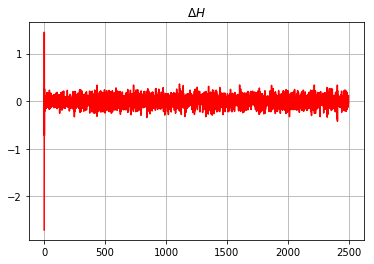

In [965]:
#plot Delta H 
plt.title('$\Delta H$'); 
xdat = range(nmeas)
plt.plot(dH,'r-',label='$x_{n}$'); 
plt.grid(True);
plt.show() 

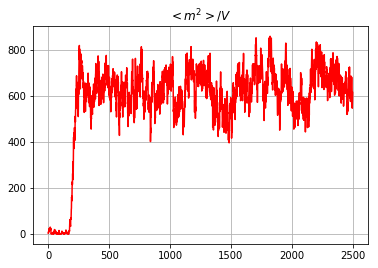

In [966]:
#plot <m^2>/V
plt.title('$< m^2 >/V$'); 
xdat = range(nmeas)
plt.plot(msq,'r-',label='$x_{n}$'); 
plt.grid(True);
plt.show() 

In [967]:
#Estimate the (unnormalized) autocorrelation for data at a single offset tau 
def autocorr(data,tau):
    tmp1=0.0
    tmp2=0.0
    tmp3=0.0
    for j in range(data.size-tau):
        tmp1 += data[j]*data[j+tau]
        tmp2 += data[j]
        tmp3 += data[j+tau]
        
    tmp1 /= (data.size-tau)
    tmp2 /= (data.size-tau)
    tmp3 /= (data.size-tau)
    return (tmp1 - tmp2*tmp3) 

In [970]:
#Data analysis. 
nremove = 500 #the number of measurements to be discarded due to thermalization
mdata = np.zeros(nmeas-nremove)
i_am_one = np.zeros(nmeas-nremove)
for j in range(nmeas-nremove):
    mdata[j] = msq[j+nremove]
    i_am_one[j] = np.exp(-dH[j+nremove])

#A good check of correctness
i_am_one_mean = np.average(i_am_one)

#the best estimate for the mean of the target observable
msq_mean = np.average(mdata)

#largest separation at which the autocorrelation should be estimated 
tau_max = 100

#compute the normalized autocorrelation function
rho_msq = np.zeros(tau_max)
rho_i_am_one = np.zeros(tau_max)
for tau in range(tau_max):
    rho_msq[tau]=autocorr(mdata,tau)
    rho_i_am_one[tau]=autocorr(i_am_one,tau)
var_msq = rho_msq[0]
rho_msq /= var_msq

var_i_am_one = rho_i_am_one[0]
rho_i_am_one /= var_i_am_one

#'integrate' the autocorrelation function to get the integrated autocorrelation time
tint_msq = np.zeros(tau_max)
tint_msq[0]=0.5
tint_i_am_one = np.zeros(tau_max)
tint_i_am_one[0]=0.5

for tau in range(tau_max-1):
    tint_msq[tau+1] = tint_msq[tau]+rho_msq[tau+1]
    tint_i_am_one[tau+1] = tint_i_am_one[tau]+rho_i_am_one[tau+1]

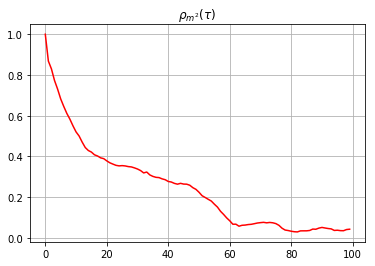

In [971]:
#plot the autocorrelation function
plt.title('$\\rho_{m^2}(\\tau)$')
xdat = range(tau_max)
plt.plot(rho_msq,'r-', label='$x_{n}$') 
plt.grid(True)
plt.show() 

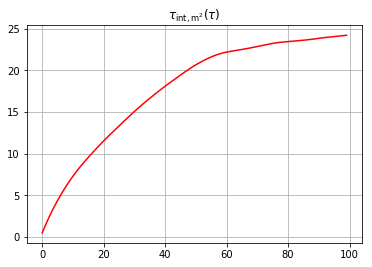

In [972]:
#plot the integrated autocorrelation time, and estimate tau_int
plt.title('$\\tau_{\\rm int, m^2}(\\tau)$')
xdat = range(tau_max)
plt.plot(tint_msq,'r-', label='$x_{n}$') 
plt.grid(True)
plt.show() 
tau_int_msq = max(tint_msq)

In [973]:
#Print the mean value and error estimate. 
print (f'<m^2> = {msq_mean} +/- {np.sqrt(2*tau_int_msq*var_msq/(nmeas-nremove))}')

<m^2> = 631.1002173996181 +/- 12.77631504724802


In [974]:
(nmeas-nremove)/(2*tau_int_msq)

41.29703259794245

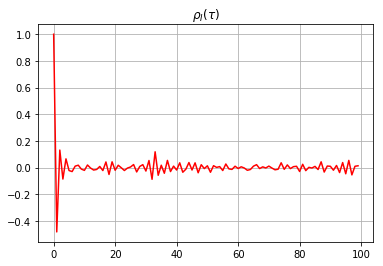

In [975]:
#plot the autocorrelation function
plt.title('$\\rho_I(\\tau)$')
xdat = range(tau_max)
plt.plot(rho_i_am_one,'r-', label='$x_{n}$') 
plt.grid(True)
plt.show() 

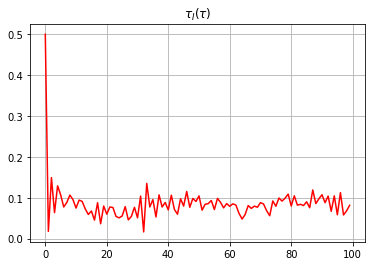

In [976]:
#plot the integrated autocorrelation time, and estimate tau_int
plt.title('$\\tau_I(\\tau)$')
xdat = range(tau_max)
plt.plot(tint_i_am_one,'r-', label='$x_{n}$') 
plt.grid(True)
plt.show() 
tau_int_i_am_one = max(tint_i_am_one)

In [981]:
#Print the mean value and error estimate. 
print (f'<exp(-Delta H)> = {i_am_one_mean} +/- {np.sqrt(var_i_am_one/(nmeas-nremove))}')

<exp(-Delta H)> = 1.0065761599281329 +/- 0.0026508781477171425


In [979]:
np.average(dH*dH)

0.017403648317878186

In [984]:
np.average(acc)

0.9516